In [2]:
####################################
#ENVIRONMENT SETUP

In [3]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [4]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [5]:
#IMPORT CLASSES (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [6]:
#IMPORT FUNCTIONS (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"Variable_Calculation"))
from FUNCTIONS_Variable_Calculation import *

In [9]:
#IMPORT FUNCTIONS

import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

In [10]:
####################################
#LOADING CLASSES

In [116]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="EntrainmentCalculation", dataName="EntrainmentCalculation",
                                dtype='int32')

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Proje

In [ ]:
####################################
#FUNCTIONS

In [13]:
#SETTING UP RUN

def LoadMeanLFC():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"MeanLFC_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     MeanLFC = pickle.load(f)
    MeanLFC=2 #*#*
    return MeanLFC
MeanLFC=LoadMeanLFC()
print(f"Mean LFC is: {MeanLFC}\n")


def LoadAllCloudBase():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"all_cloudbase_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     all_cloudbase = pickle.load(f)
    all_cloudbase=1 #*#*
    return(all_cloudbase)
min_all_cloudbase=np.nanmin(LoadAllCloudBase())
cloudbase=min_all_cloudbase
print(f"Minimum Cloudbase is: {cloudbase}\n")

Mean LFC is: 2

Minimum Cloudbase is: 1



In [ ]:
#CALCULATING ENTRAINMENT

PROCESSING=False #*#*
# PROCESSING=True

def GetEntrainment_T(t,varName):
    timeString=ModelData.timeStrings[t]
    output = CallVariable(ModelData, DataManager, timeString, variableName=varName)
    return output

def Mean_YX(output):
    output_mean_yx = np.mean(output,axis=(1,2))
    return output_mean_yx

def GetEntrainment_MeanTZ(varName):
    outputArray = np.zeros((ModelData.Ntime,ModelData.Nzh))
    for t in range(ModelData.Ntime):
        if np.mod(t,10)==0: print(f'Current time {t}')

        if 'Detrainment' in varName and t == ModelData.Ntime-1:
            continue
        else:
            variable = GetEntrainment_T(t,varName)
            variableMean_yx = Mean_YX(variable)
            outputArray[t] = variableMean_yx
    return outputArray

In [151]:
#APPLYING ENTRAINMENT CONSTANT
def ApplyEntrainmentConstant(arrayDictionary):
    """
    Multiply each array in the input dictionary by the 1D entrainment constant profile.
    Returns the processed arrays in the same order as the input dictionary.
    """
    entrainmentConstant = DataManager.Load1DVariable(
        DataManager.outputDataDirectory,
        dataName="EntrainmentConstant"
    )["entrainmentConstant"]

    outputDictionary = {}
    for var_name, arr in arrayDictionary.items():
        outputDictionary[var_name] = arr * entrainmentConstant[np.newaxis, :]

    # Return arrays in the same order as input
    return tuple(outputDictionary[var_name] for var_name in arrayDictionary.keys())

In [152]:
####################################
#CALCULATING

In [153]:
#entrainment

profile_array_e_g = GetEntrainment_MeanTZ('Entrainment_g')
profile_array_e_c = GetEntrainment_MeanTZ('Entrainment_c')
profile_array_d_g = GetEntrainment_MeanTZ('Detrainment_g')
profile_array_d_c = GetEntrainment_MeanTZ('Detrainment_c')

arrayDictionary = {
    "profile_array_e_g": profile_array_e_g,
    "profile_array_e_c": profile_array_e_c,
    "profile_array_d_g": profile_array_d_g,
    "profile_array_d_c": profile_array_d_c
}

[profile_array_e_g,
 profile_array_e_c,
 profile_array_d_g,
 profile_array_d_c] = ApplyEntrainmentConstant(arrayDictionary)

Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Loaded 1D variable file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Pro

In [173]:
#transfer entrainment
profile_array_c_to_g_E = GetEntrainment_MeanTZ('TransferEntrainment_c_to_g')
profile_array_g_to_c_E = GetEntrainment_MeanTZ('TransferEntrainment_g_to_c')
profile_array_c_to_g_D = GetEntrainment_MeanTZ('TransferDetrainment_c_to_g')
profile_array_g_to_c_D = GetEntrainment_MeanTZ('TransferDetrainment_c_to_g')

arrayDictionary = {
    "profile_array_c_to_g_E": profile_array_c_to_g_E,
    "profile_array_g_to_c_E": profile_array_g_to_c_E,
    "profile_array_c_to_g_D": profile_array_c_to_g_D,
    "profile_array_g_to_c_D": profile_array_g_to_c_D
}

[profile_array_c_to_g_E,
 profile_array_g_to_c_E,
 profile_array_c_to_g_D,
 profile_array_g_to_c_D] = ApplyEntrainmentConstant(arrayDictionary)

Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Current time 0
Current time 10
Current time 20
Current time 30
Current time 40
Current time 50
Current time 60
Current time 70
Current time 80
Current time 90
Current time 100
Current time 110
Current time 120
Current time 130
Loaded 1D variable file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Pro

In [154]:
####################################
#PLOTTING FUNCTIONS

In [155]:
def GetData(type):
    if type=='general':
        profile_array_e=profile_array_e_g
        profile_array_d=-profile_array_d_g
        profile_array_net=profile_array_e-profile_array_d
    if type=='cloudy':
        profile_array_e=profile_array_e_c
        profile_array_d=-profile_array_d_c
        profile_array_net=profile_array_e-profile_array_d

    return profile_array_e,profile_array_d,profile_array_net

In [156]:
def plot_mean_entrainment(ax, profile_array_e, profile_array_d, title, linestyle='solid'):
    zh=ModelData.zh

    # Compute mean profiles
    e = np.mean(profile_array_e, axis=0)
    d = np.mean(profile_array_d, axis=0)
    net = np.mean(profile_array_e - profile_array_d, axis=0)

    # Plot
    ax.plot(e, zh, linestyle=linestyle, color='blue', label='Entrainment')
    ax.plot(d, zh, linestyle=linestyle, color='red', label='Detrainment')
    ax.plot(net, zh, linestyle=linestyle, color='black', label='Net Entrainment')
    ax.axvline(0, color='gray', linestyle='dashed',zorder=-10)

    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC / 1000, color='green', linestyle='dashed', lw=1.2)

    ax.grid(True)
    ax.set_title(f"{title}",fontsize=10.5)
    ax.set_xlabel(r"($kg\ m^{-3}\ s^{-1}$)")  
    ax.set_ylabel('z (km)')
    ax.set_ylim(bottom=0)
    ax.legend(loc='upper right')
    ax.set_ylim(0,20)

    #FIXED TICKS
    SnapLimitsToTicks([ax], dim='x')

    
    # Format x-axis in scientific notation
    apply_scientific_notation([ax],decimals=2)

In [157]:
def SaveFigure(fig,filename):
    save_dir = f"PLOTS/{res}_{t_res}_{Np_str}"
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(f"{save_dir}/{filename}_{res}_{t_res}_{Np_str}.jpg", dpi=300, bbox_inches='tight')

In [158]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
def Plot_EntrainmentDetrainmentRows(array_triplets, type_labels, plotting=True):
    if not plotting:
        return
        
    cmap1 = plt.cm.viridis
    cmap2 = plt.cm.seismic 
    n_levels = 29
    z_lim=20

    num_rows = len(array_triplets)

    fig = plt.figure(figsize=(18, 4 * num_rows))
    gs = GridSpec(num_rows, 4, figure=fig)
    all_ax1, all_ax2, all_ax3 = [], [], []
    
    for row_idx, ((profile_array_e, profile_array_d, profile_array_net), type_label) in enumerate(zip(array_triplets, type_labels)):
        vmax_shared = np.max([np.max(profile_array_e), np.max(profile_array_d)])
        norm_shared = mcolors.Normalize(vmin=0, vmax=vmax_shared)
        norm_shared = None

        y = ModelData.zh
        x = np.arange(profile_array_e.shape[0])

        mins=(ModelData.time[1].astype(int)/1e9/60)
        plot_kwargs = {
            'PlotData': None,
            'xTickLabels': x, 'yTickLabels': y,
            'contour_type': 'line',#'fill',
            'num_xticks': 11, 'round_xticks': None, 'xTickInterval': 60/mins,
            'num_yticks': 15, 'round_yticks': 2, 'yTickInterval': None,
            'add_colorbar': True, 'fig': fig, 'levels': 29, 'colorbar_label_rotation': 0, 'colorbar_label': None,
            'xlabel': "t (hours)", 'ylabel': "z (km)",
            'solid_contour_labels': False, 'solid_contour_round': None,
            'xtick_rotation': 0, 'ytick_rotation': 0, 'cbar_rotation': 0,
            'save_path': None, 'save_dpi': 300,
            'colorbar_kwargs': {
                'extend': 'both'
            },
            'norm': norm_shared
        }

        ax1 = fig.add_subplot(gs[row_idx, 0])
        ax2 = fig.add_subplot(gs[row_idx, 1])
        ax3 = fig.add_subplot(gs[row_idx, 2])

        all_ax1.append(ax1)
        all_ax2.append(ax2)
        all_ax3.append(ax3)

        plot_kwargs1 = plot_kwargs.copy()
        plot_kwargs1['PlotData'] = profile_array_e.copy().T
        plot_kwargs1['cmap'] = cmap1
        [contour1, cbar1] = UltimateContourPlot(ax1, **plot_kwargs1)
        ax1.set_ylim(0, z_lim)
        ax1.set_title(f'Entrainment {type_label}',fontsize=8)

        plot_kwargs2 = plot_kwargs.copy()
        plot_kwargs2['PlotData'] = profile_array_d.copy().T
        plot_kwargs2['cmap'] = cmap1
        [contour2, cbar2] = UltimateContourPlot(ax2, **plot_kwargs2)
        ax2.set_ylim(0, z_lim)
        ax2.set_title(f'Detrainment {type_label}',fontsize=8)

        plot_data3 = profile_array_net.copy().T
        vmin = -np.max(abs(profile_array_net)) / 2
        vmax = +np.max(abs(profile_array_net))
        levels = np.linspace(vmin, vmax, n_levels)
        norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

        plot_kwargs3 = plot_kwargs.copy()
        plot_kwargs3['PlotData'] = plot_data3
        plot_kwargs3['cmap'] = cmap2
        plot_kwargs3['norm'] = norm
        plot_kwargs3['levels'] = levels
        [contour3, cbar3] = UltimateContourPlot(ax3, **plot_kwargs3)
        ax3.set_ylim(0, 19)
        ax3.set_title(f'Net Entrainment {type_label}',fontsize=8)
        # fig.suptitle(f"{type_labels[row_idx][0].upper() + type_labels[row_idx][1:]} Updraft Entrainment/Detrainment")

        def apply_scientific_notation_colorbar(cbars):
            from matplotlib.ticker import ScalarFormatter
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            for cbar in cbars:
                cbar.formatter = formatter
                cbar.update_ticks()

        apply_scientific_notation_colorbar([cbar1, cbar2, cbar3])

        #FIXING CONTOUR COLORBAR LINES THICKNESS
        for cbar in [cbar1, cbar2, cbar3]:
            for cbar_line in cbar.ax.collections:
                cbar_line.set_linewidth(3)

        for ax in [ax1,ax2,ax3]:
            ax.axhline(cloudbase, color='purple', linestyle='dashed',lw=1.2)
            ax.axhline(MeanLFC / 1000, color='green', linestyle='dashed',lw=1.2)
            xticks = ax.get_xticks()
            new_labels = [f"{tick*mins/(60)+6:.0f}" for tick in xticks]
            ax.set_xticklabels(new_labels)

    ticks = np.linspace(0, z_lim, num=11)
    for ax in all_ax1 + all_ax2 + all_ax3:# + [ax4, ax5]:
        ax.set_ylim([0, z_lim])
        ax.set_yticks(ticks)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.margins(y=0)
            
    ax4 = fig.add_subplot(gs[0, 3])
    ax5 = fig.add_subplot(gs[1, 3])
    plot_mean_entrainment(ax4, profile_array_e1, profile_array_d1, title='Mean Vertical Profile')
    plot_mean_entrainment(ax5, profile_array_e2, profile_array_d2, title='Mean Vertical Profile')

    #SPACING
    fig.subplots_adjust(top=0.92, wspace=0.4, hspace=0.4)
    
    # #SAVING
    # filename=f"Entrainment_ContourPlot_DomainProfiles"
    # SaveFigure(fig,filename) #*#*

In [159]:
####################################
#PLOTTING

In [160]:
#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e1,profile_array_d1,profile_array_net1]=GetData(type=type1)
[profile_array_e2,profile_array_d2,profile_array_net2]=GetData(type=type2)

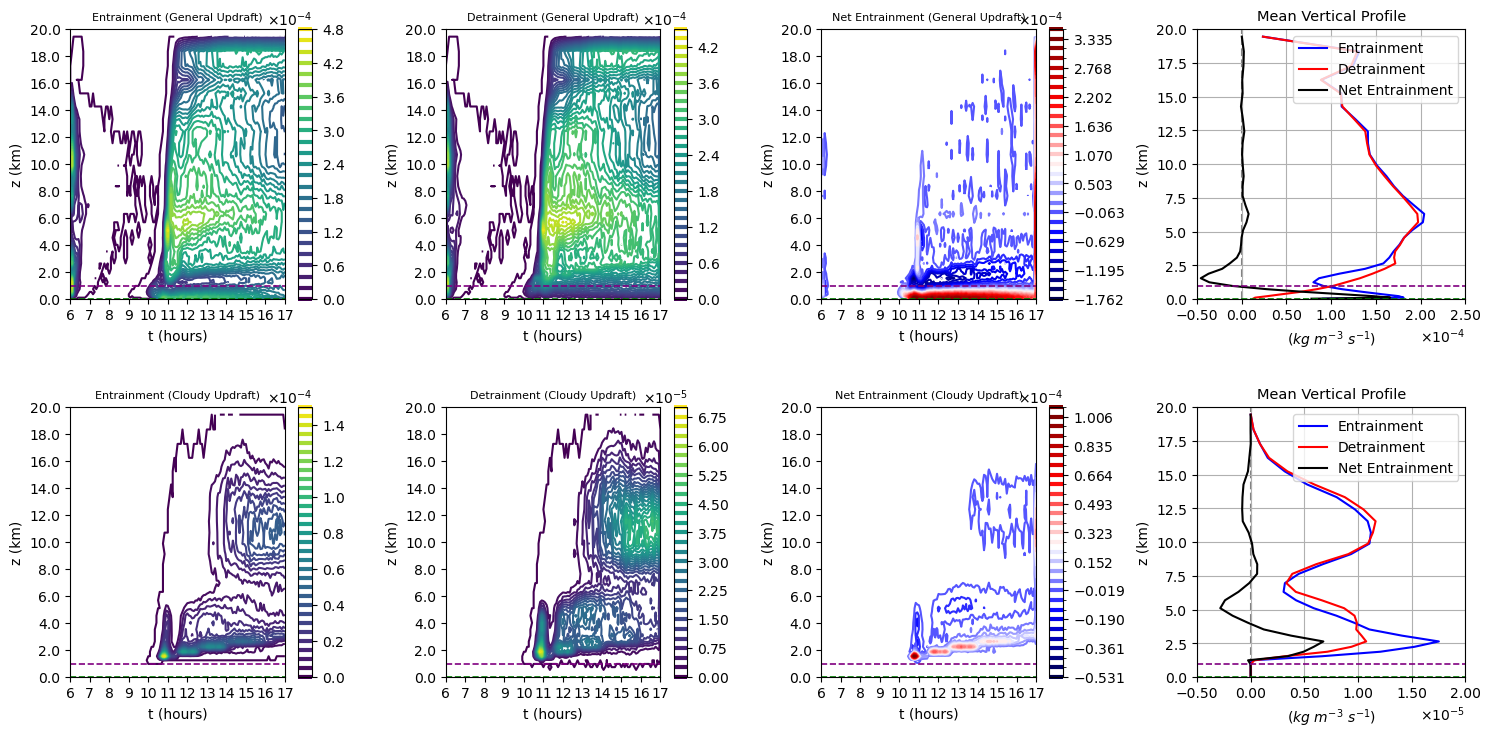

In [161]:
#CONTOUR PLOTS
array_triplets = [
    (profile_array_e1, profile_array_d1, profile_array_net1),
    (profile_array_e2, profile_array_d2, profile_array_net2)
]
type_labels = ['(General Updraft)', '(Cloudy Updraft)']

Plot_EntrainmentDetrainmentRows(array_triplets, type_labels)

In [ ]:
#COMBINED ENTRAINMENT

In [176]:
def compute_means_for_transfer(c_to_g_E, g_to_c_E, c_to_g_D, g_to_c_D,
                               profile_array_e_g, profile_array_e_c,
                               profile_array_d_g, profile_array_d_c):
    """Compute and return mean profiles for transfer rates and entrainment/detrainment arrays."""

    # Compute means of transfer rates
    c_to_g_E_mean = np.mean(c_to_g_E, axis=0)
    g_to_c_E_mean = np.mean(g_to_c_E, axis=0)
    c_to_g_D_mean = np.mean(c_to_g_D, axis=0)
    g_to_c_D_mean = np.mean(g_to_c_D, axis=0)

    # Compute means of entrainment/detrainment profiles
    mean_e_g = np.mean(profile_array_e_g, axis=0)
    mean_e_c = np.mean(profile_array_e_c, axis=0)
    mean_d_g = np.mean(profile_array_d_g, axis=0)
    mean_d_c = np.mean(profile_array_d_c, axis=0)

    return {
        'c_to_g_E_mean': c_to_g_E_mean,
        'g_to_c_E_mean': g_to_c_E_mean,
        'c_to_g_D_mean': c_to_g_D_mean,
        'g_to_c_D_mean': g_to_c_D_mean,
        'mean_e_g': mean_e_g,
        'mean_e_c': mean_e_c,
        'mean_d_g': mean_d_g,
        'mean_d_c': mean_d_c
    }

    
def plot_transfer_rate(ax, means, title):
    zh = ModelData.zh

    c_to_g_mean_E = means['c_to_g_E_mean']
    g_to_c_mean_E = means['g_to_c_E_mean']
    c_to_g_mean_D = means['c_to_g_D_mean']
    g_to_c_mean_D = means['g_to_c_D_mean']

    # ax.plot(g_to_c_mean_E, zh, color='blue', label='General → Cloudy',linestyle='solid')
    # ax.plot(c_to_g_mean_E, zh, color='red', label='Cloudy → General',linestyle='solid')
    ax.plot(g_to_c_mean_E, zh, color='blue', label='General → Cloudy (Entrainment)',linestyle='solid')
    ax.plot(c_to_g_mean_E, zh, color='red', label='Cloudy → General (Entrainment)',linestyle='solid')
    ax.plot(c_to_g_mean_D, zh, color='blue', label='Cloudy → General (Detrainment)',linestyle='dashed')
    ax.plot(g_to_c_mean_D, zh, color='red', label='General → Cloudy (Detrainment)',linestyle='dashed')
    ax.axvline(0, color='black', linewidth=1)

    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC / 1000, color='forestgreen', linestyle='dashed', lw=1.2)

    ax.grid(True)
    ax.set_title(f"{title}")
    ax.set_xlabel('Mass Transfer Rate')
    ax.set_xlabel(r"($kg m^{-3} s^{-1}$)")  
    ax.set_ylabel('z (km)')
    ax.set_ylim(bottom=0,top=20)
    ax.legend()
    
    SnapLimitsToTicks([ax], dim='x')
    apply_scientific_notation([ax],decimals=2)

def plot_transfer_ratio(ax, means, title):
    zh = ModelData.zh

    mean_e_g = means['mean_e_g']
    mean_e_c = means['mean_e_c']
    mean_d_g = means['mean_d_g']
    mean_d_c = means['mean_d_c']
    
    mean_c_to_g_E = means['c_to_g_E_mean']
    mean_g_to_c_E = means['g_to_c_E_mean']
    mean_c_to_g_D = means['c_to_g_D_mean']
    mean_g_to_c_D = means['g_to_c_D_mean']

    threshold = 0
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio_1 = np.where(mean_e_c > threshold, mean_g_to_c_E / mean_e_c, np.nan)
        ratio_2 = np.where(mean_d_g > threshold, mean_g_to_c_D / mean_d_g, np.nan)
        ratio_3 = np.where(mean_e_g > threshold, mean_c_to_g_E / mean_e_g, np.nan)
        ratio_4 = np.where(mean_d_c > threshold, mean_c_to_g_D / mean_d_c, np.nan)

    # print(np.nanmean(ratio_1))
    # print(np.nanmean(ratio_2))
    # print(np.nanmean(ratio_3))
    # print(np.nanmean(ratio_4))

    ax.plot(ratio_1*100, zh, color='blue', label='General → Cloudy / Cloudy Entrainment')
    ax.plot(ratio_2*100, zh, color='deepskyblue', label='General → Cloudy / General Detrainment')
    ax.plot(ratio_3*100, zh, color='red', label='Cloudy → General / General Entrainment')
    ax.plot(ratio_4*100, zh, color='orangered', label='Cloudy → General / Cloudy Detrainment')

    ax.axvline(0, color='black', linestyle='dashed', linewidth=1)
    # ax.axvline(1, color='black', linestyle='dashed', linewidth=1)
    ax.axvline(100, color='black', linestyle='dashed', linewidth=1)
    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC / 1000, color='green', linestyle='dashed', lw=1.2)

    ax.grid(True)
    ax.set_title(f"{title}")
    # ax.set_xlabel('Ratio')
    ax.set_xlabel('%')
    ax.set_ylabel('z (km)')
    # ax.set_xlim(-0.05, 1.05)
    ax.set_xlim(-5, 105)
    ax.set_ylim(bottom=0,top=20)
    ax.legend(fontsize=10.5-2, loc='upper right')
    # apply_scientific_notation([ax])


In [177]:
#LOAD DATA
type1='general';type2='cloudy'
[profile_array_e1,profile_array_d1,profile_array_net1]=GetData(type=type1)
[profile_array_e2,profile_array_d2,profile_array_net2]=GetData(type=type2)

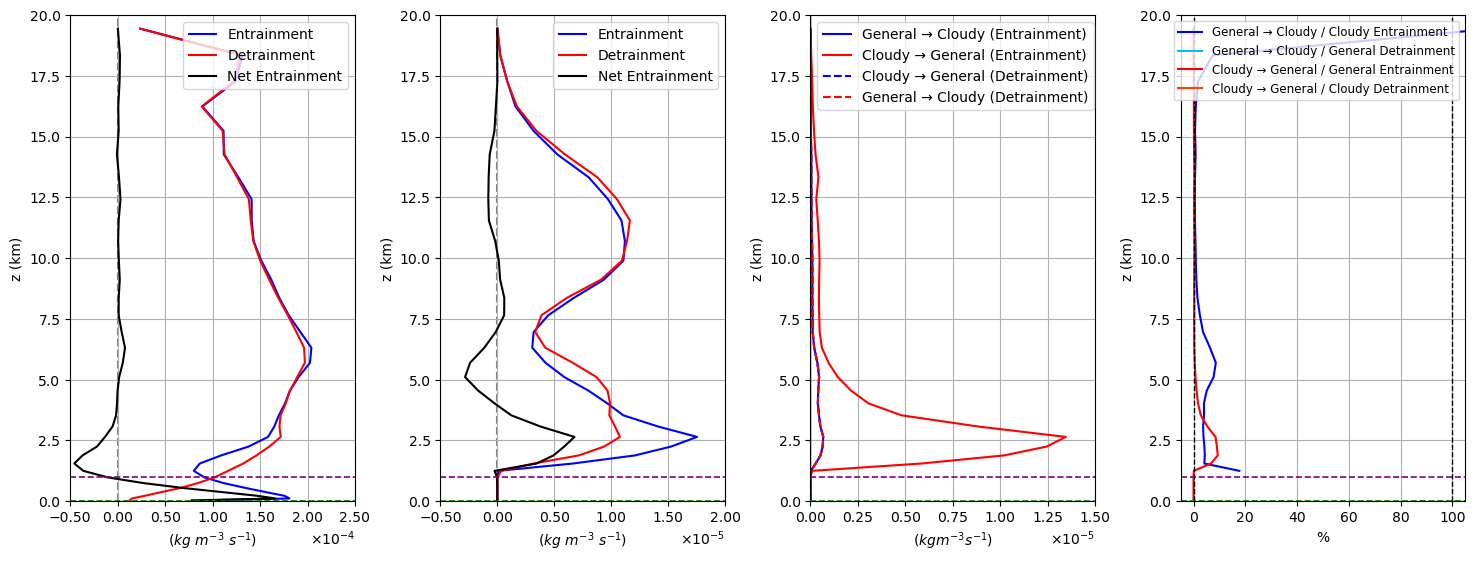

In [178]:
# === Compute means for transfer rate and ratio plots ===
means = compute_means_for_transfer(
    c_to_g_E=profile_array_c_to_g_E,
    g_to_c_E=profile_array_g_to_c_E,
    c_to_g_D=profile_array_c_to_g_D,
    g_to_c_D=profile_array_g_to_c_D,
    profile_array_e_g=profile_array_e_g,
    profile_array_e_c=profile_array_e_c,
    profile_array_d_g=profile_array_d_g,
    profile_array_d_c=profile_array_d_c
)

# === Set up figure and subplots ===
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 4, figure=fig, wspace=0.3, )


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# === Plot each panel ===
plot_mean_entrainment(ax1, profile_array_e1, profile_array_d1, title='')
plot_mean_entrainment(ax2, profile_array_e2, profile_array_d2, title='')
plot_transfer_rate(ax3, means, title='')
plot_transfer_ratio(ax4, means, title='')
fig.subplots_adjust(top=0.92, wspace=0.4, hspace=0.4)


# # === Save figure === #*#*
# filename = "Combined_Entrainment_VerticalProfiles"
# SaveFigure(fig, filename)